## Census Income Prediction

In [95]:
# Data Manipulation 
import numpy as np
import pandas as pd
import math

# Visualization 
import matplotlib.pyplot as plt
import missingno # 缺失值顯示用
import seaborn as sns
#from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler
from sklearn.feature_selection import RFE, RFECV

# Machine learning 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
#import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score, auc, accuracy_score, classification_report

# Managing Warnings 
#import warnings
#warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline
sns.set_style("whitegrid")

## Objective
我們的任務：預測一個人的收入能否超過五萬美元

人口普查數據集: https://archive.ics.uci.edu/ml/datasets/adult

In [3]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
           'marital-status', 'occupation', 'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv('dataset/adult.data', header=None, names=headers, sep=',\s', na_values=["?"], engine='python')
test_raw = pd.read_csv('dataset/adult.test', header=None, names=headers, sep=',\s', na_values=["?"], engine='python', skiprows=1)

In [4]:
# Join Datasets
dataset_raw = training_raw.append(test_raw)
dataset_raw = dataset_raw.reset_index(drop=True)
dataset_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


* age	年齡	double
* workclass	工作類型	string
* fnlwgt	序號	string
* education	教育程度	string
* education_num	受教育時間	double
* maritial_status	婚姻狀況	string
* occupation	職業	string
* relationship	關係	string
* race	種族	string
* sex	性別	string
* capital_gain	資本收益	string
* capital_loss	資本損失	string
* hours_per_week	每週工作小時數	double
* native_country	國籍	string
* income	收入	string

## 單特徵分析

關於特症，我們可以分析單特徵，也可以分析不同特徵之間的關係，首先來看單特徵

特徵簡單分為兩種：類別型和數值型
- **Numerical:** 都是數
- **Categorical:** 種類或者字符串

In [17]:
# 展示所有數值型(Numerical)的特徵
dataset_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [19]:
# 展示所有種類型(Categorical)的特徵
dataset_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,predclass
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


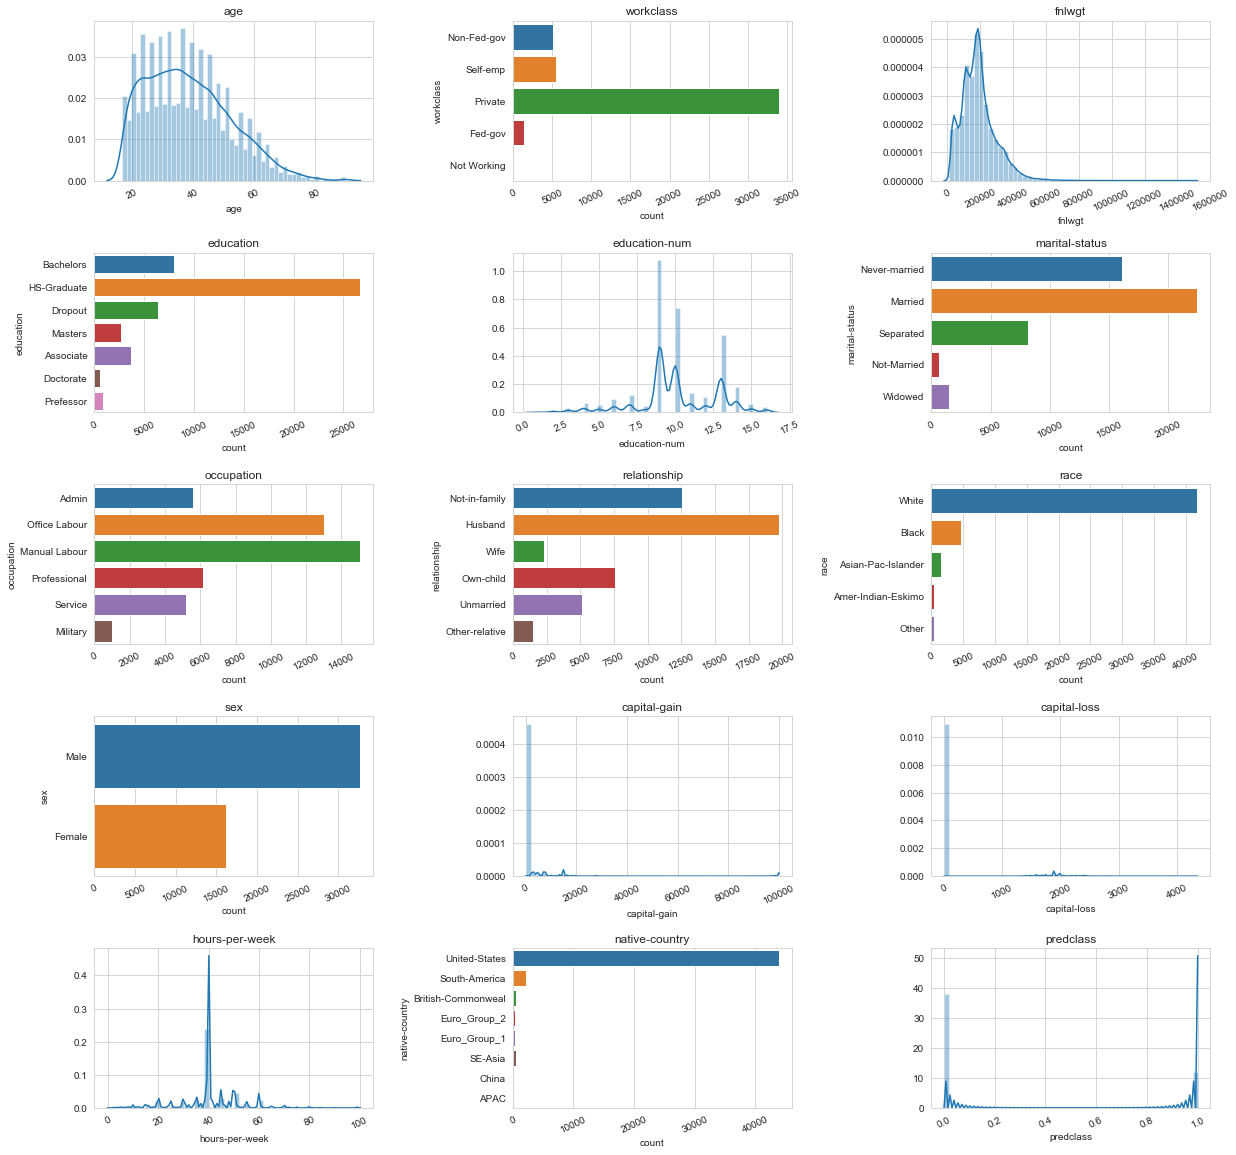

In [63]:
# 單特徵展示
def plot_distribution(dataset, cols=5, width=20, height=20, hspace=0.45, wspace=0.5): # hspace, wspace: 圖與圖的間距
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    
    rows = math.ceil(float(dataset.shape[1] / cols))
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        
        # 如果該行不是數值，計算每個字串出現次數
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            g.set(yticklabels=[s.get_text()[:18] for s in g.get_yticklabels()]) #限制字串長度,這樣圖畫起來比較美觀            
            plt.xticks(rotation=25)
            
        # 如果是數值則畫出直方圖
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
            
plot_distribution(dataset_raw, cols=3)

#### 缺失值顯示

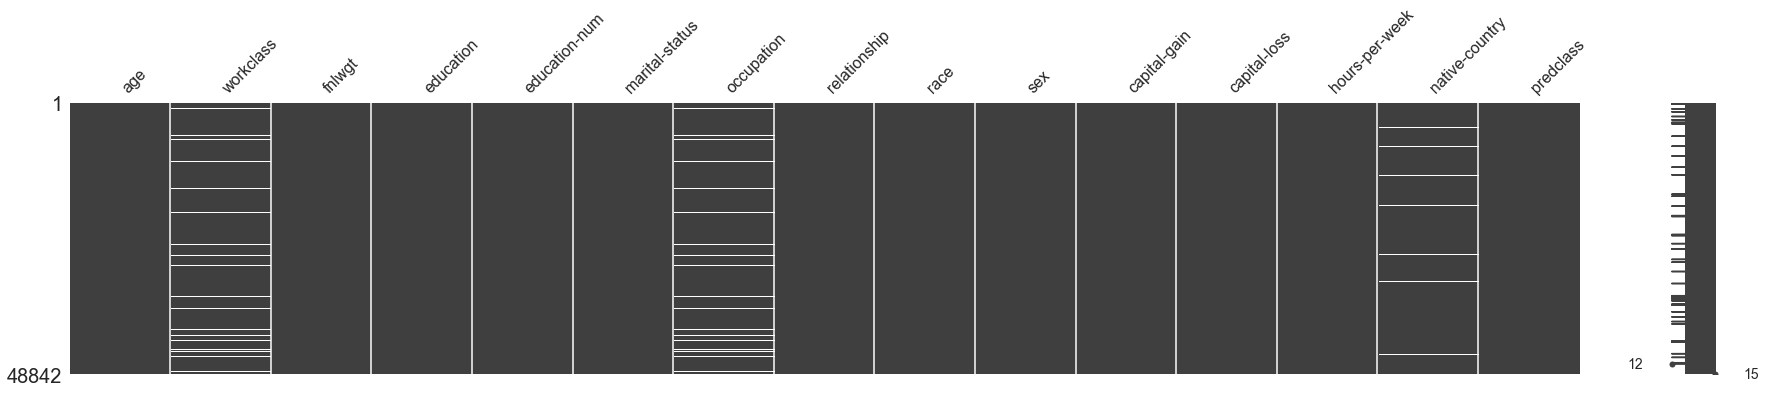

In [23]:
missingno.matrix(dataset_raw, figsize=(30,5))

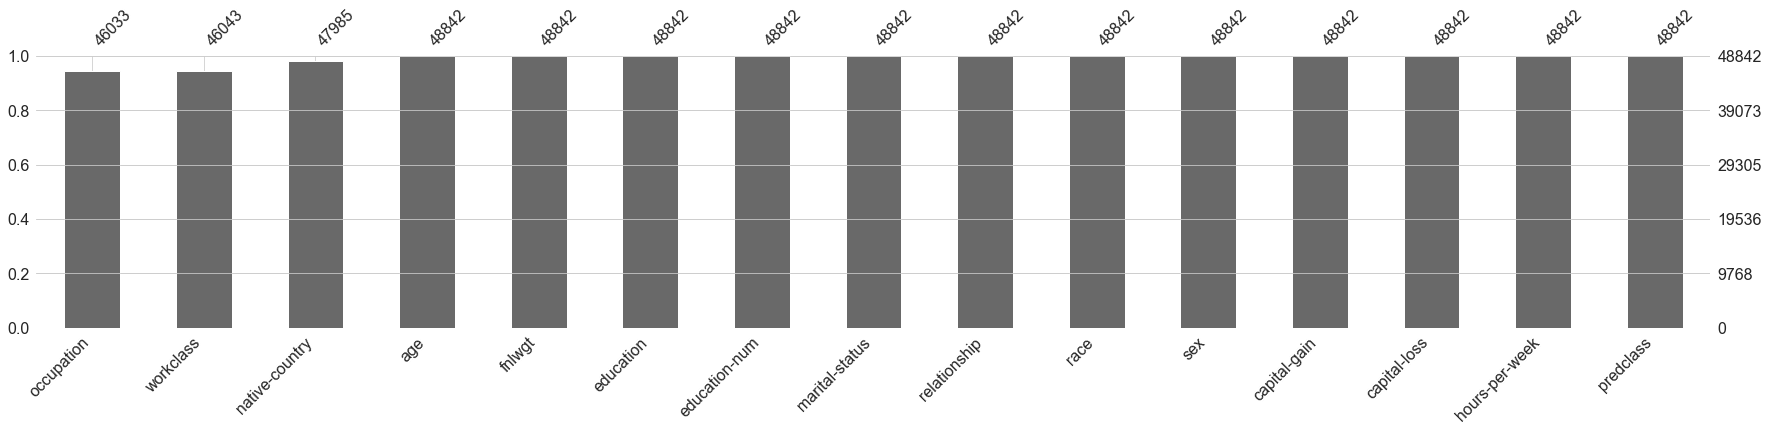

In [24]:
missingno.bar(dataset_raw, sort='ascending', figsize=(30,5))

## 清洗：Feature Cleaning、特徵工程：Feature Engineering

**清洗(Feature Cleaning):**
數據預處理(Preprocessing)工作

- **缺失值:** 對缺失值進行填充 (ex. 分箱均值填充)
- **特殊值:** 一些錯誤導致的特殊值，例如 ±Inf, NA NaN
- **離群點:** 這些點可能會對结果產生影響，先把它們找出来
- **錯誤值:** 比如人的年齡不可能出現負數

**特徵工程(Feature Engineering):**
There are multiple techniques for feature engineering
- **特徵分解:** 比如將時間數據2014-09-20T20:45:40Z 轉化成天，小時等信息
- **離散化:** 我們可以選擇離散一些我們所擁有的連續變量(ex. 年齡分箱)，因为一些算法會執行得更快。但是會對结果產生什麼樣的影響呢？需要比較離散和非離散的建模结果
<br>dataset_bin => 連續值被離散化的數據集
<br>dataset_con => 非離散化的數據集

- **特徵组合:** 將不同的特徵组合成一个新特徵
    
**缺失值問題:**
填補缺失值：

- **額外的數據填充** 
- **均值填充:** 這樣可以不改變當前數據集整體的均值
- **回歸模型預測:** 建立一个回歸模型去得到預測值

In [5]:
# 創建兩個新的數據集
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables 
dataset_con = pd.DataFrame() # To contain our dataframe with our continuous variables 

#### 標籤轉換

如果輸入大於 $50K. 那麼就是1 反之就是0

In [6]:
# Let's fix the Class Feature
dataset_raw.loc[dataset_raw['predclass'] == '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '>50K.','predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == '<=50K.','predclass'] = 0

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

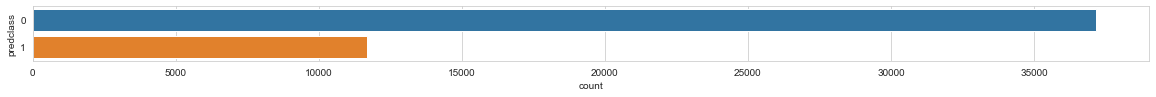

In [7]:
# 數據不太均衡
plt.figure(figsize=(20,1))
sns.countplot(y='predclass', data=dataset_raw)

#### Feature : Age


In [8]:
# 將連續值進行切分
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10)

# non-discretised
dataset_con['age'] = dataset_raw['age']

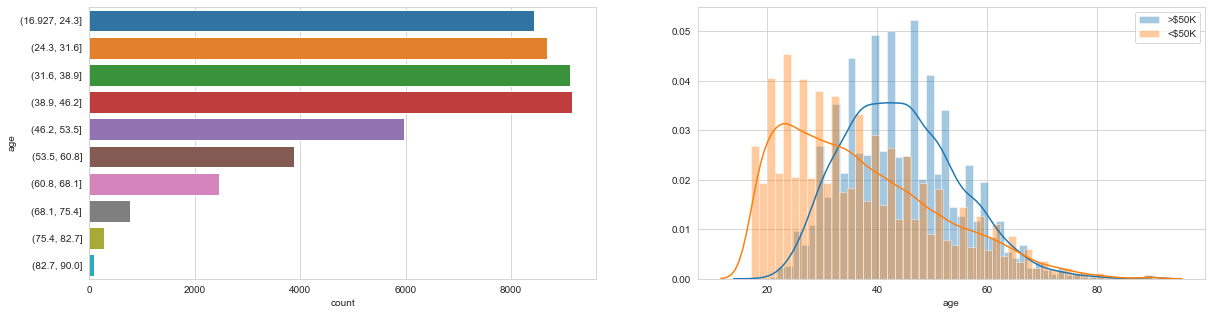

In [9]:
# 左圖是切分後的结果 右圖是根據不同的收入等級劃分
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(y='age', data=dataset_bin)

plt.subplot(1,2,2)
sns.distplot(dataset_con[dataset_con['predclass']==1]['age'], label='>$50K')
sns.distplot(dataset_con[dataset_con['predclass']==0]['age'], label='<$50K')
plt.legend()

#### Feature : Workclass

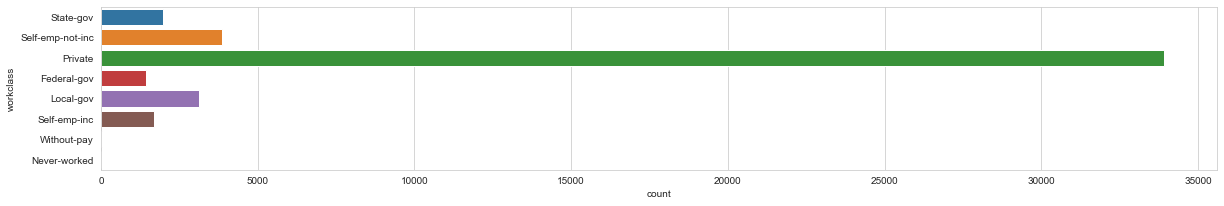

In [10]:
# 工作的種類
plt.figure(figsize=(20,3))
sns.countplot(y='workclass', data=dataset_raw)

In [11]:
dataset_raw['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', nan, 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [12]:
# 種類有些太多了，有些類似的要進行合併
dataset_raw.loc[dataset_raw['workclass']=='Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass']=='Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass']=='Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass']=='State-gov', 'workclass'] = 'Non-Fed-gov'
dataset_raw.loc[dataset_raw['workclass']=='Local-gov', 'workclass'] = 'Non-Fed-gov'
dataset_raw.loc[dataset_raw['workclass']=='Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass']=='Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

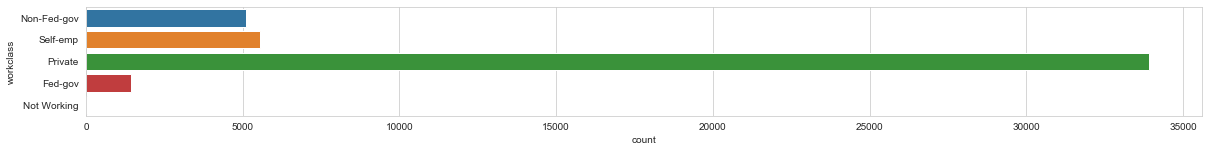

In [13]:
plt.figure(figsize=(20,2))
sns.countplot(y='workclass', data=dataset_raw)

#### Feature : Final Weight 序號

In [14]:
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10) # 同樣分成10份
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

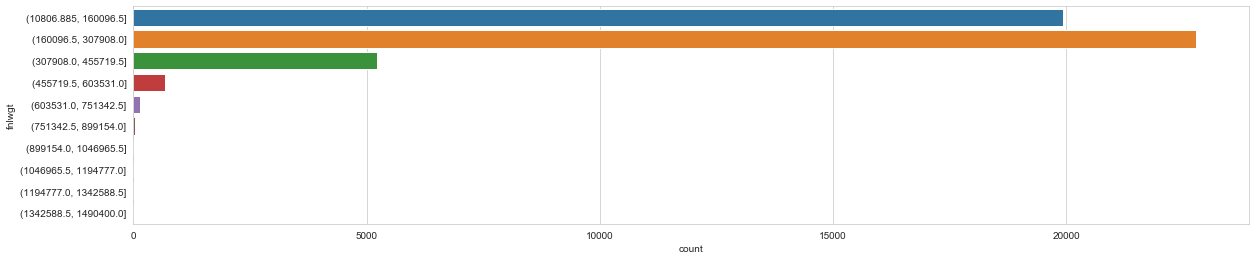

In [15]:
plt.figure(figsize=(20,4))
sns.countplot(y='fnlwgt', data=dataset_bin)

#### Feature : Education

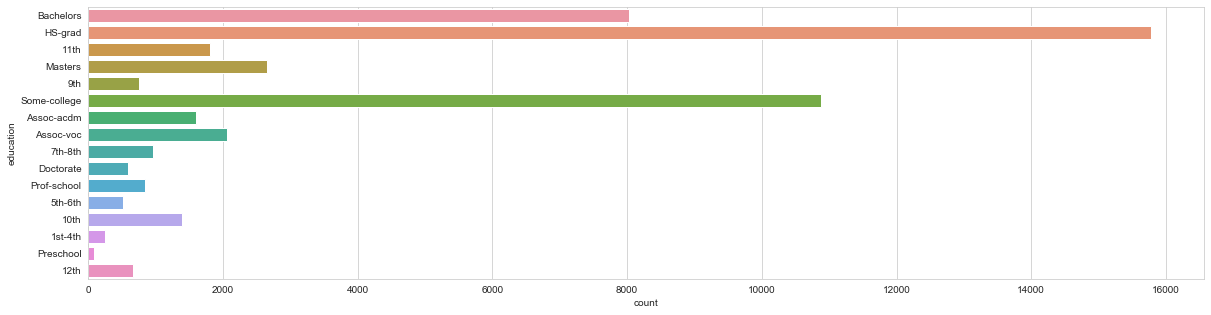

In [16]:
# 教育也進行合併
plt.figure(figsize=(20,5))
sns.countplot(y='education', data=dataset_raw)

In [17]:
dataset_raw['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [18]:
dataset_raw.loc[dataset_raw['education']=='10th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='11th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='12th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='1st-4th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='5th-6th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='7th-8th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='9th', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='Preschool', 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education']=='Assoc-acdm', 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education']=='Assoc-voc', 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education']=='HS-grad', 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education']=='Some-college', 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education']=='Prof-school', 'education'] = 'Prefessor'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

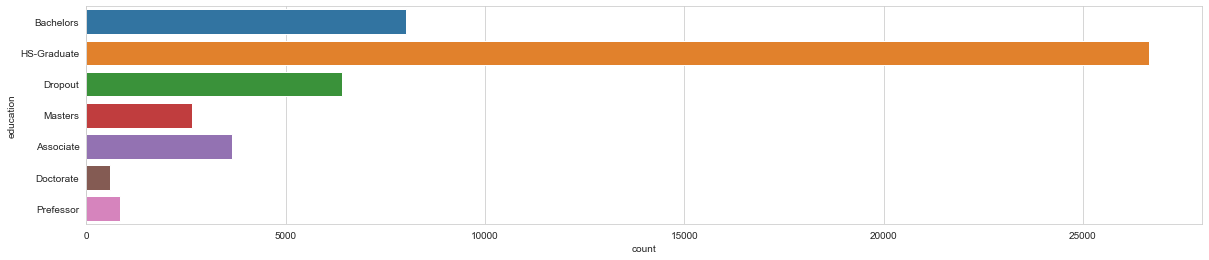

In [19]:
plt.figure(figsize=(20,4))
sns.countplot(y='education', data=dataset_raw)

#### Feature : Education Number

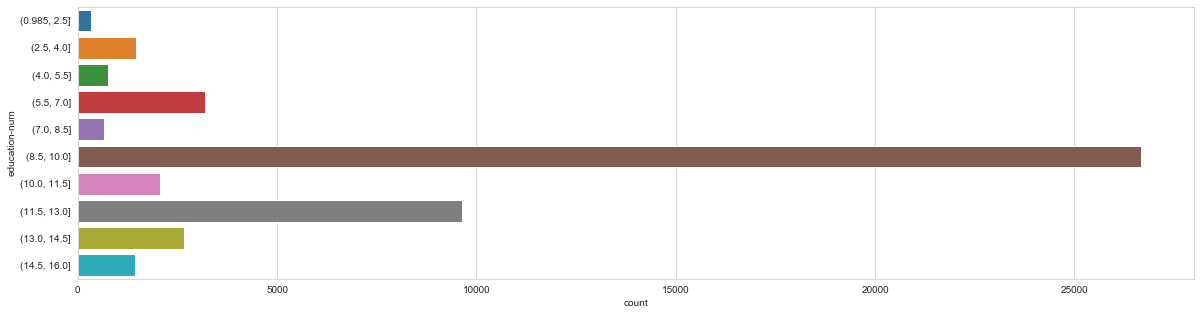

In [20]:
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

plt.figure(figsize=(20,5))
sns.countplot(y='education-num', data=dataset_bin)

#### Feature : Marital Status

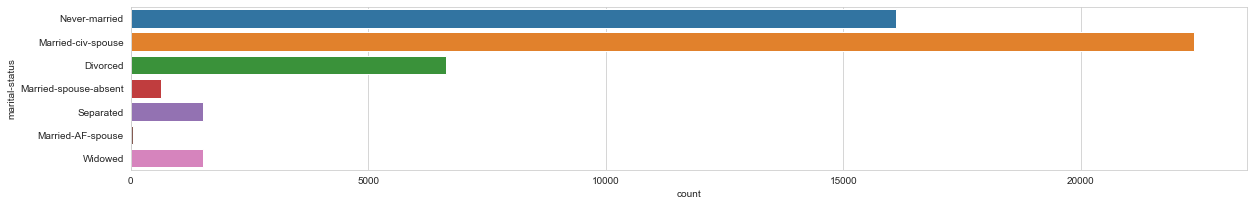

In [21]:
# 婚姻狀況
plt.figure(figsize=(20,3))
sns.countplot(y='marital-status', data=dataset_raw)

In [22]:
dataset_raw['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

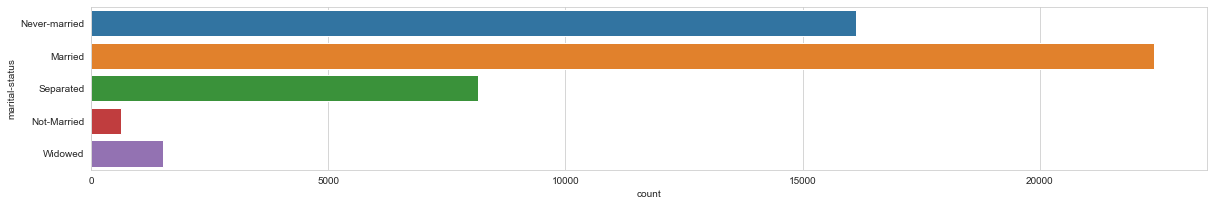

In [23]:
dataset_raw.loc[dataset_raw['marital-status']=='Married-civ-spouse', 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status']=='Married-AF-spouse', 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status']=='Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status']=='Separated', 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status']=='Divorced', 'marital-status'] = 'Separated'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

plt.figure(figsize=(20,3))
sns.countplot(y='marital-status', data=dataset_raw)

#### Feature : Occupation

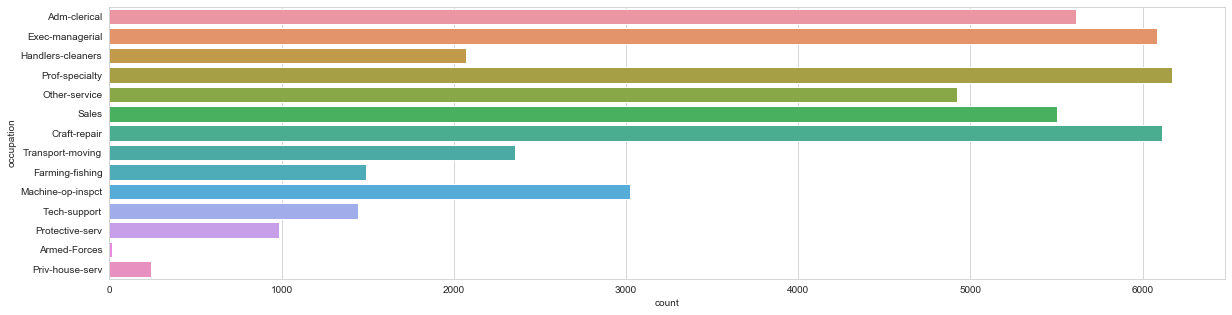

In [24]:
# 職業也是重複的太多了
plt.figure(figsize=(20,5))
sns.countplot(y='occupation', data=dataset_raw)

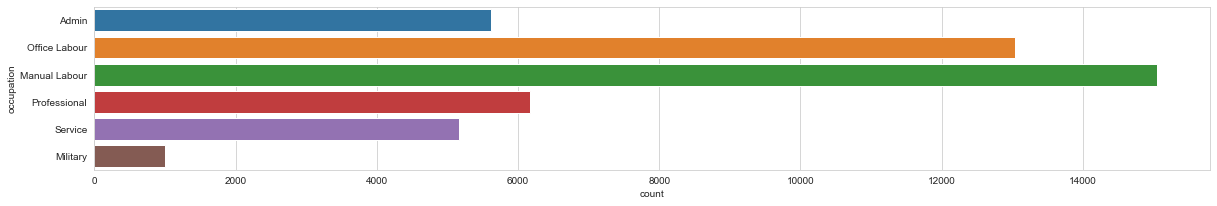

In [25]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation']=='Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation']=='Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation']=='Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation']=='Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation']=='Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation']=='Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation']=='Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation']=='Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation']=='Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation']=='Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation']=='Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation']=='Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation']=='Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation']=='Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

plt.figure(figsize=(20,3))
sns.countplot(y='occupation', data=dataset_raw)

#### Feature : Capital Gain

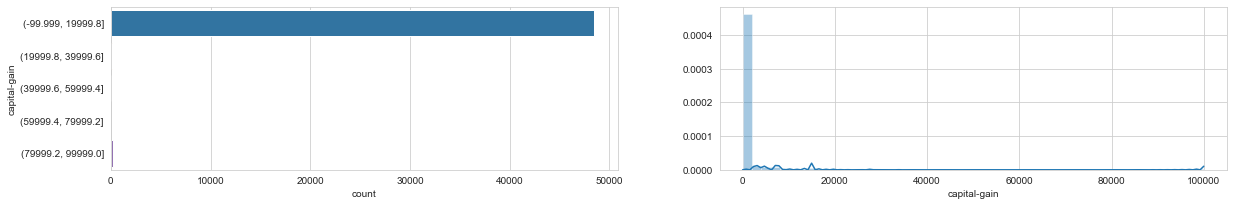

In [26]:
#資本增益
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
sns.countplot(y='capital-gain', data=dataset_bin)

plt.subplot(1,2,2)
sns.distplot(dataset_con['capital-gain'])

#### Feature : Capital Loss

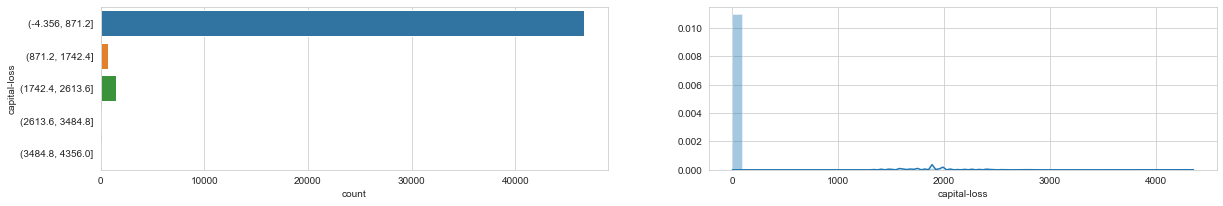

In [27]:
# 資本損失
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
sns.countplot(y='capital-loss', data=dataset_bin)

plt.subplot(1,2,2)
sns.distplot(dataset_con['capital-loss'])

#### Feature : Hours per Week

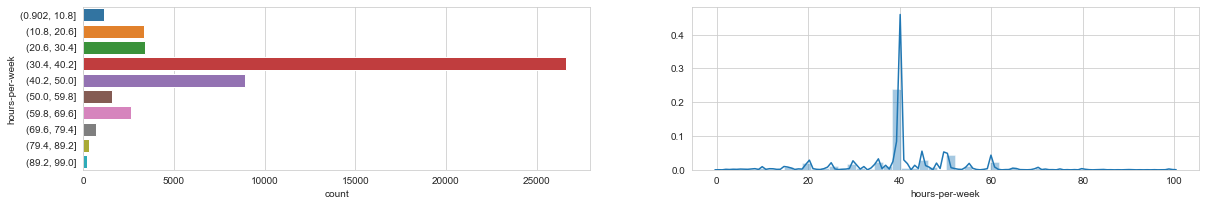

In [28]:
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
sns.countplot(y='hours-per-week', data=dataset_bin)

plt.subplot(1,2,2)
sns.distplot(dataset_con['hours-per-week'])

#### Feature : Native Country

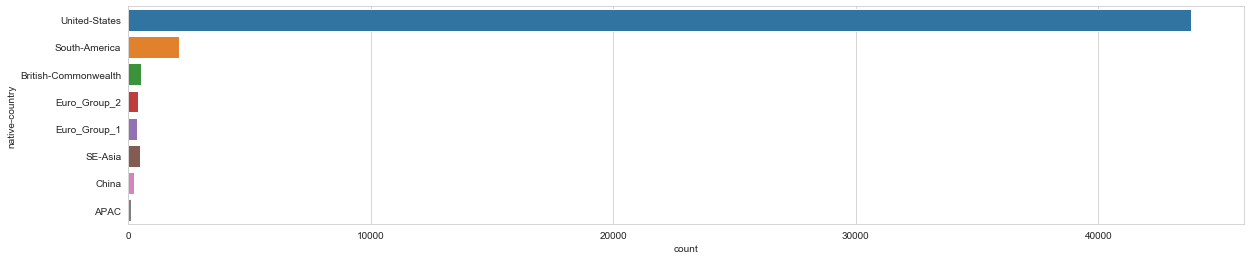

In [29]:
# 同樣進行合併
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

fig = plt.figure(figsize=(20,4)) 
sns.countplot(y='native-country', data=dataset_raw)

#### Features : Race, Sex, Relationship

In [30]:
# 這些就直接用了
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

## 雙變量分析

接下來要看特徵之間的關係了

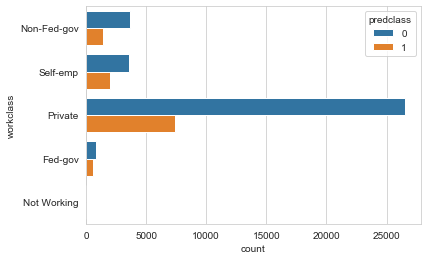

In [31]:
sns.countplot(x=None, y='workclass', hue='predclass', data=dataset_raw[['predclass','workclass','occupation']])

#### 在不同類別屬性上觀察兩種標籤的分佈情況

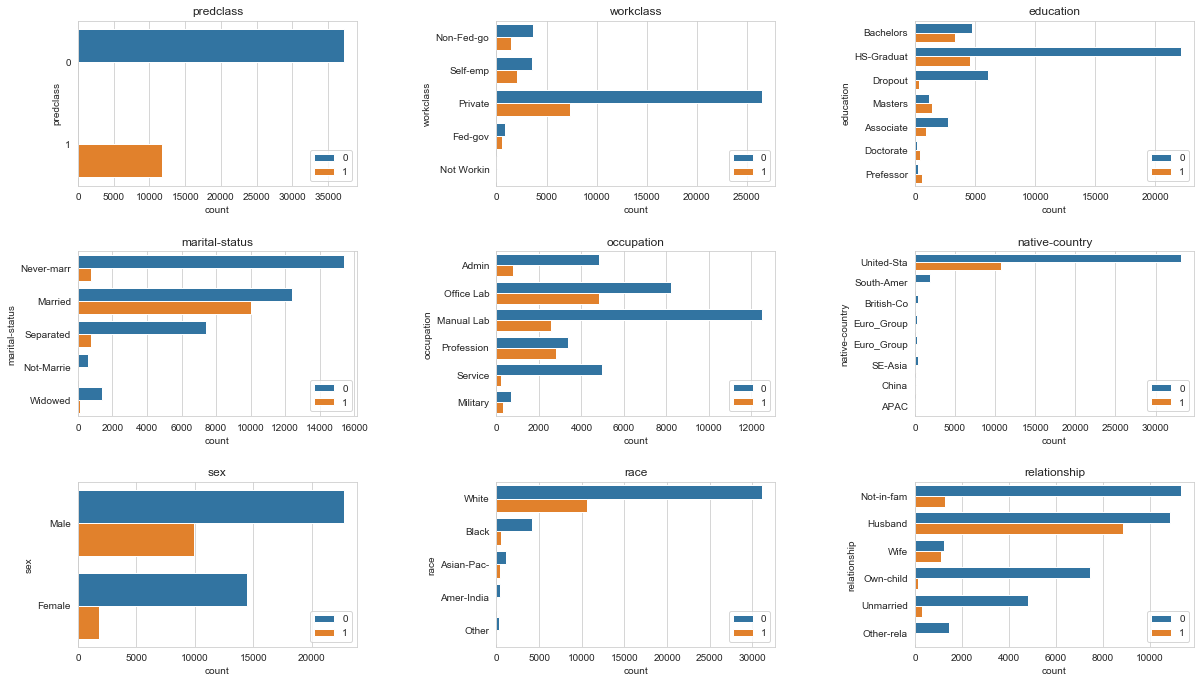

In [32]:
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=20, hspace=0.4, wspace=0.5):
    
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    
    i = 0
    for _, column in enumerate(dataset.columns):
        
        if (dataset.dtypes[column] == np.object) | (column == hue):
            ax = fig.add_subplot(rows, cols, i+1)
            ax.set_title(column)
            
            g = sns.countplot(x=None, y=column, hue=hue, data=dataset)
            g.set(yticklabels=[s.get_text()[:10] for s in g.get_yticklabels()])
            plt.legend(loc='lower right')
            i += 1

plot_bivariate_bar(dataset_con, hue='predclass', cols=3)

/Users/dan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


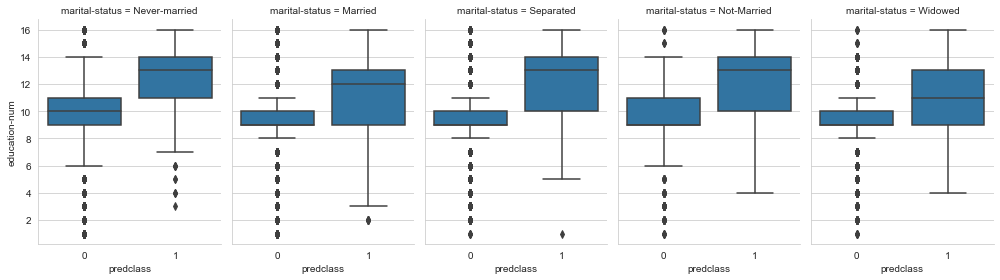

In [33]:
# 婚姻狀況和教育對收入的影響
g = sns.FacetGrid(dataset_con, col='marital-status', height=4, aspect=.7)
g.map(sns.boxplot, 'predclass', 'education-num')

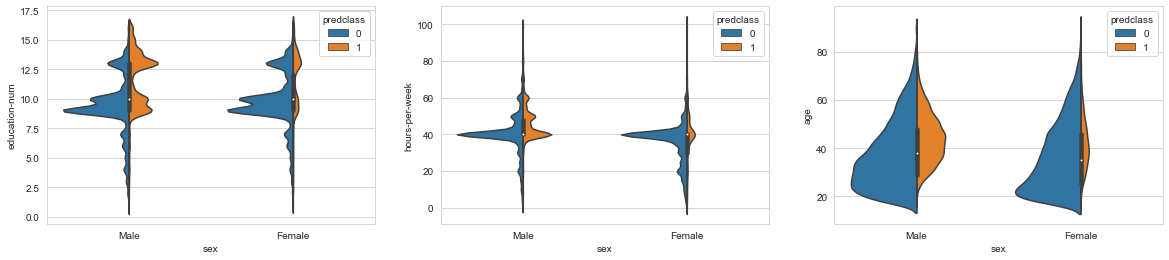

In [34]:
# 性別、教育對收入的影響
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count')

plt.subplot(1,3,2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count')

plt.subplot(1,3,3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count')

/Users/dan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/dan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


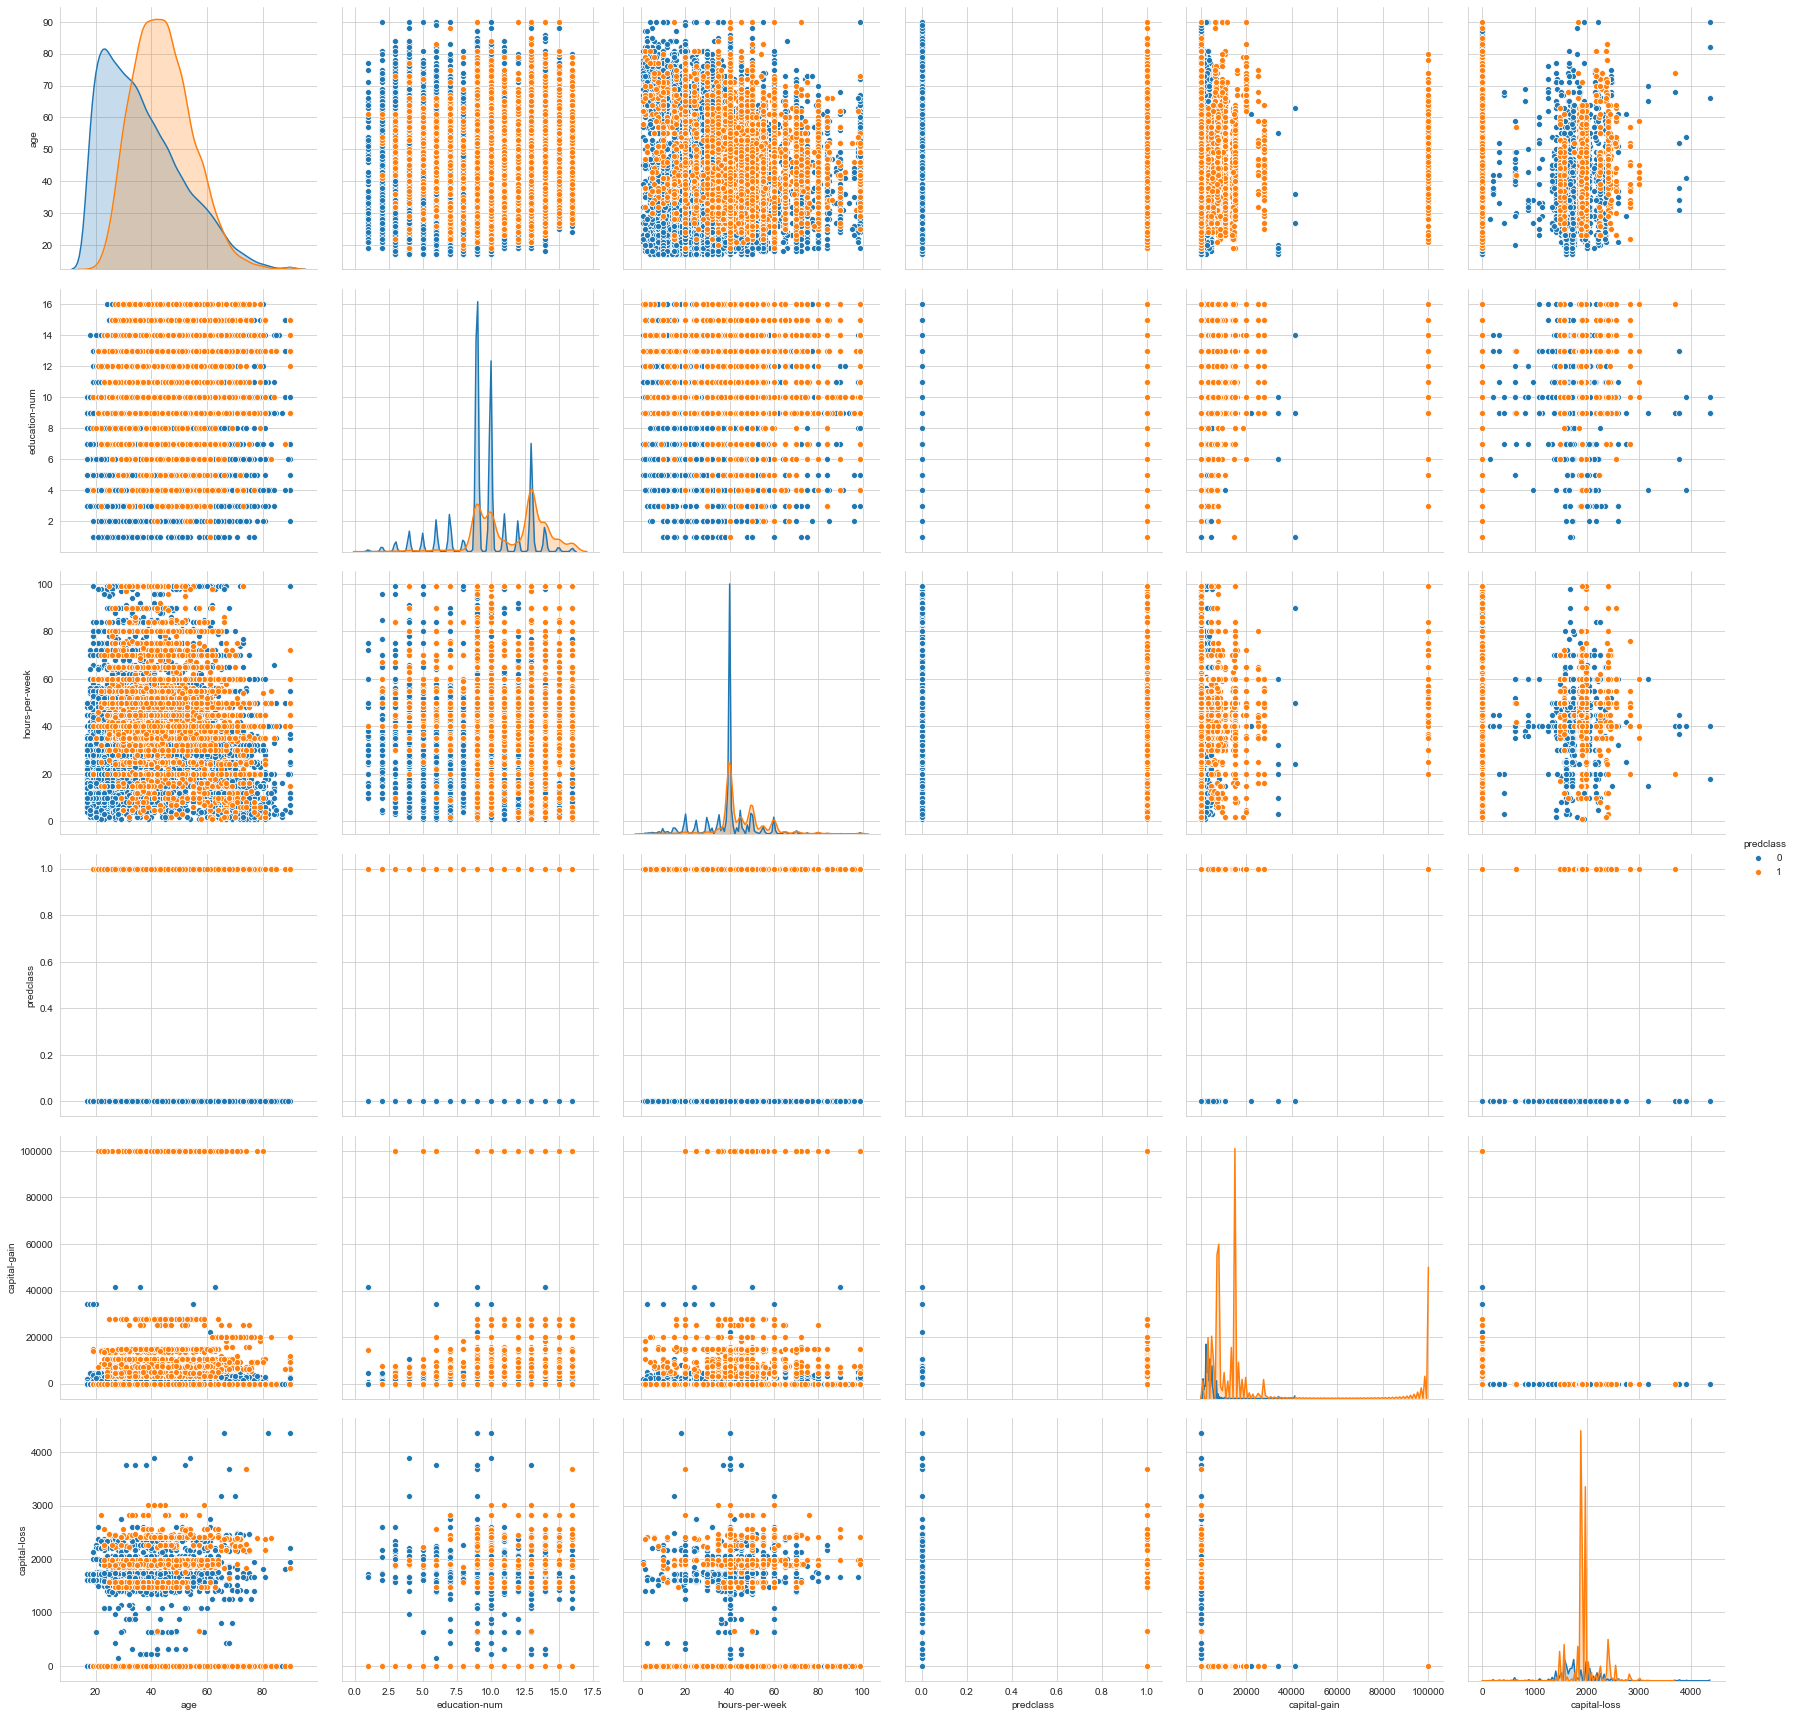

In [35]:
# 不同特徵之間的散點圖分佈
sns.pairplot(dataset_con[['age','education-num','hours-per-week','predclass','capital-gain','capital-loss']], 
             hue='predclass', diag_kind='kde',height=4)

## 特徵組合 Feature Crossing

開發新的變量

#### Crossing Numerical Features

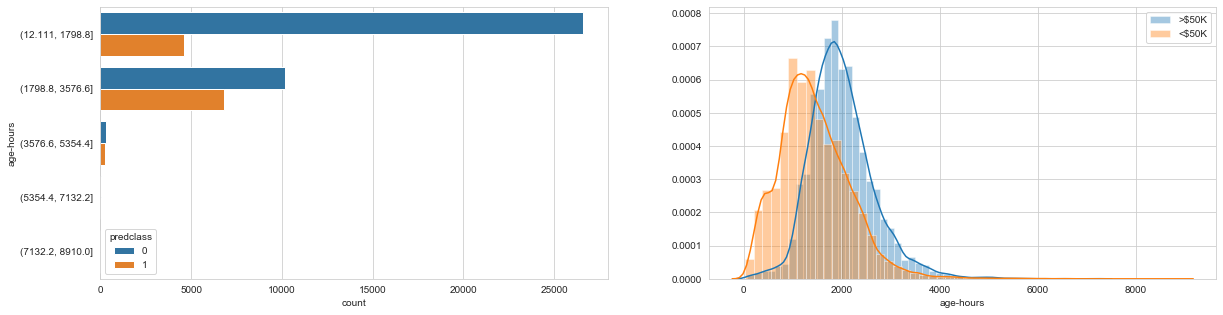

In [36]:
dataset_raw['age-hours'] = dataset_raw['age'] * dataset_raw['hours-per-week']
dataset_bin['age-hours'] = pd.cut(dataset_raw['age-hours'], 5)
dataset_con['age-hours'] = dataset_raw['age-hours']

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(y='age-hours',hue='predclass',data=dataset_bin)

plt.subplot(1,2,2)
sns.distplot(dataset_con[dataset_con['predclass']==1]['age-hours'], label='>$50K')
sns.distplot(dataset_con[dataset_con['predclass']==0]['age-hours'], label='<$50K')
plt.legend()

#### Crossing Categorical Features

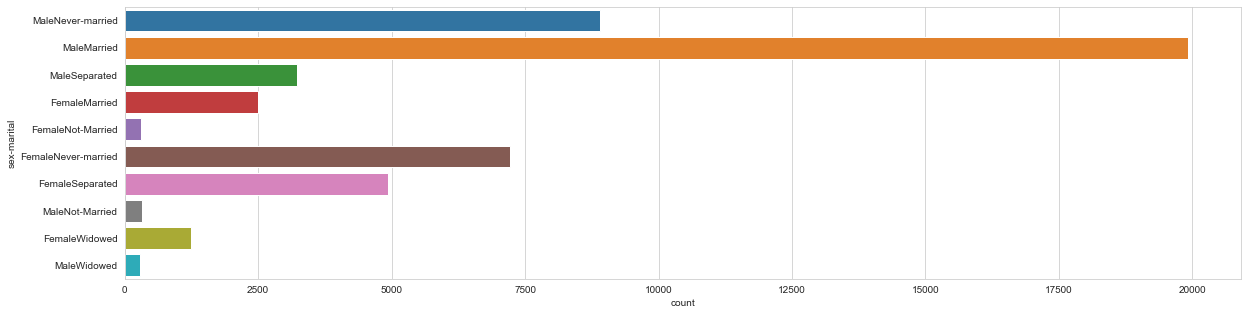

In [37]:
# 性別和婚姻
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

plt.figure(figsize=(20,5))
sns.countplot(y='sex-marital', data=dataset_bin)

## Feature Encoding

對特徵進行編碼，因為機器學習只認識數字
Additional Resources: http://pbpython.com/categorical-encoding.html

#### One Hot Encoding

In [38]:
one_hot_cols = dataset_bin.columns.to_list()
one_hot_cols.remove('predclass')

dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)
dataset_bin_enc.head()

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [39]:
dataset_con.head()

,predclass,age,workclass,fnlwgt,education,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,sex,race,relationship,age-hours,sex-marital
0,0,39,Non-Fed-gov,77516,Bachelors,13,Never-married,Admin,2174,0,40,United-States,Male,White,Not-in-family,1560,MaleNever-married
1,0,50,Self-emp,83311,Bachelors,13,Married,Office Labour,0,0,13,United-States,Male,White,Husband,650,MaleMarried
2,0,38,Private,215646,HS-Graduate,9,Separated,Manual Labour,0,0,40,United-States,Male,White,Not-in-family,1520,MaleSeparated
3,0,53,Private,234721,Dropout,7,Married,Manual Labour,0,0,40,United-States,Male,Black,Husband,2120,MaleMarried
4,0,28,Private,338409,Bachelors,13,Married,Professional,0,0,40,South-America,Female,Black,Wife,1120,FemaleMarried


#### Label Encoding
Two Ways: 1. use LabelEncoder(), 2. use pd.factorize()

In [40]:
# from sklearn.preprocessing import LabelEncoder

label_enc_cols = ['workclass','education','marital-status','occupation','native-country','sex','race','relationship','sex-marital']
dataset_con_enc = dataset_con

for column in label_enc_cols:
    dataset_con_enc[column] = dataset_con[column].factorize()[0]

dataset_con_enc.head()

,predclass,age,workclass,fnlwgt,education,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,sex,race,relationship,age-hours,sex-marital
0,0,39,0,77516,0,13,0,0,2174,0,40,0,0,0,0,1560,0
1,0,50,1,83311,0,13,1,1,0,0,13,0,0,0,1,650,1
2,0,38,2,215646,1,9,2,2,0,0,40,0,0,0,0,1520,2
3,0,53,2,234721,2,7,1,2,0,0,40,0,0,1,1,2120,1
4,0,28,2,338409,0,13,1,3,0,0,40,1,1,1,2,1120,3


## Feature Extraction 特徵提取、特徵選擇 Feature Selection

特徵多並不代表都是好用的，挑出比較有價值的才留下來

- **降維:**
    - **主成分分析 (PCA):** 降维最常用的手段，需要指定基座標系，然後變換到指定的维度
    - **奇異值分解 (SVD):** 找出來有具有特定含義的特徵
    - **線性判别分析 (LDA):** 拿到最適合分類的特徵空間


- **特徵重要性/相關性:**
    - **篩選:** 找出来哪些對结果最能產生影響的特徵
    - **評估子集:** 用部分特徵數據進行實驗
    - **集成方法:** 類似隨機森林

#### 特徵相關性

兩個隨機變量共同變化的相關度量。特徵應該彼此不相關，同時與我們試圖預測的特性高度相關。

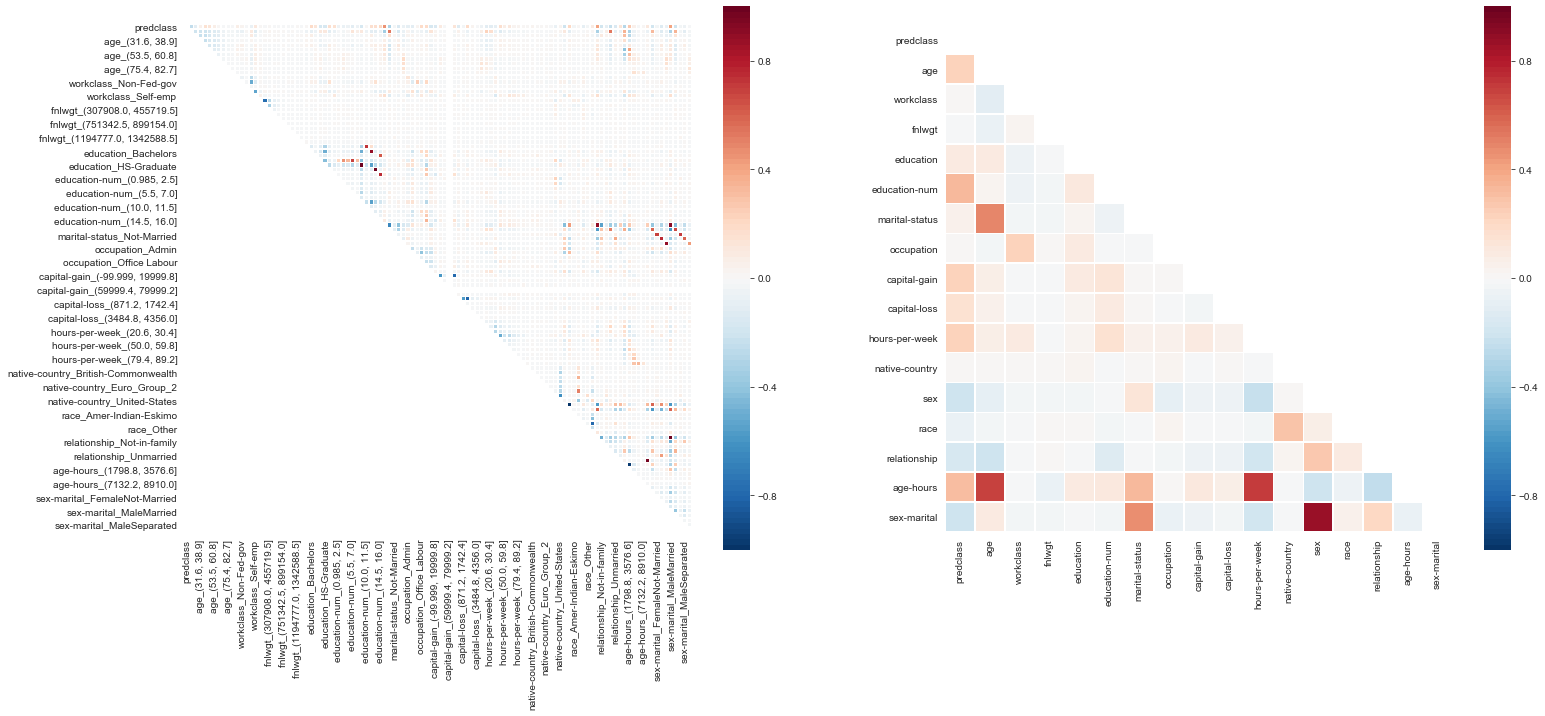

In [41]:
# 創建兩個數據集的相關圖
plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True #取上三角
sns.heatmap(dataset_bin_enc.corr(), mask=mask, vmin=-1, vmax=1, square=True, cmap=sns.color_palette("RdBu_r", 100),linewidths=.5)

plt.subplot(1,2,2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True #取下三角
sns.heatmap(dataset_con_enc.corr(), mask=mask, vmin=-1, vmax=1, square=True, cmap=sns.color_palette("RdBu_r", 100),linewidths=.5)

#### 特徵重要性

可以基於隨機森林來進行特徵重要性的評估 <br> Using Random Forest to gain an insight on Feature Importance

/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


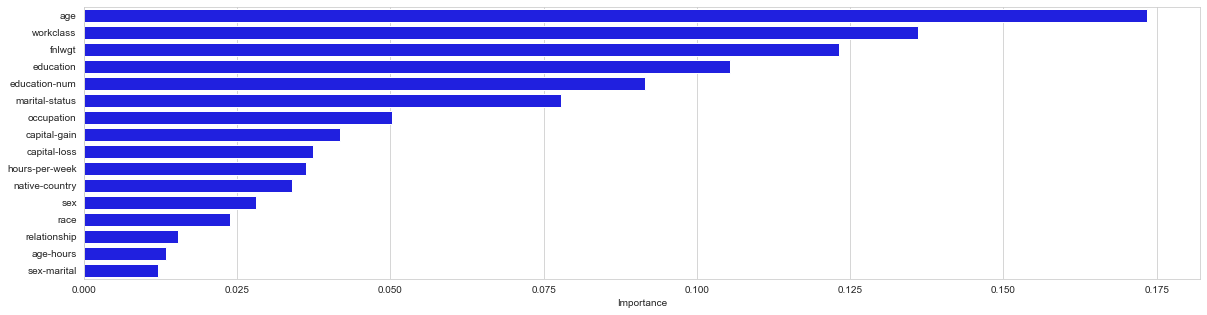

In [42]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(dataset_con_enc.drop('predclass',axis=1), dataset_con_enc['predclass'])

importance = pd.DataFrame(rfc.feature_importances_, index=dataset_con_enc.drop('predclass',axis=1).columns, columns=['Importance'])
plt.figure(figsize=(20,5))
sns.barplot(x='Importance', y=importance.index, data=importance.sort_values(by='Importance', ascending=False), color='blue')

#### 主成分分析 PCA

到底降不降维？没有一个固定的說法，在機器學習中没有說一個算法、一個方案就一定對的，需要嘗試

涉及參數：
* n_components：這個参数可以幫我們指定希望PCA降维後的特徵维度數目。最常用的做法是直接指定降维到要的维度数目，此時n_components是一個 大於等於1 的整數。我们也可以指定主成分的方差和所占的最小比例阈值(threshold)，讓PCA類自己去根據樣本特徵方差來決定降维到的维度數，此时n_components是一個（0，1) 之間的數

* whiten：判断是否進行白化。所謂白化，就是對降维後的數據的每個特徵進行歸一化，讓方差都為1，對於PCA降维本身來說，一般不需要白化。如果你PCA降维後有後續的數據處理動作，可以考慮白化。默認值是False，即不進行白化。 

* 除了這些輸入参數外，有兩個PCA類的成員值得關注。第一個是explained_variance_，它代表降维後的各主成分的方差值。方差值越大，則說明越是重要的主成分。第二個是explained_variance_ratio_，它代表降维後的各主成分的方差值占總方差值的比例，这个比例越大，则越是重要的主成分。

<BarContainer object of 15 artists>

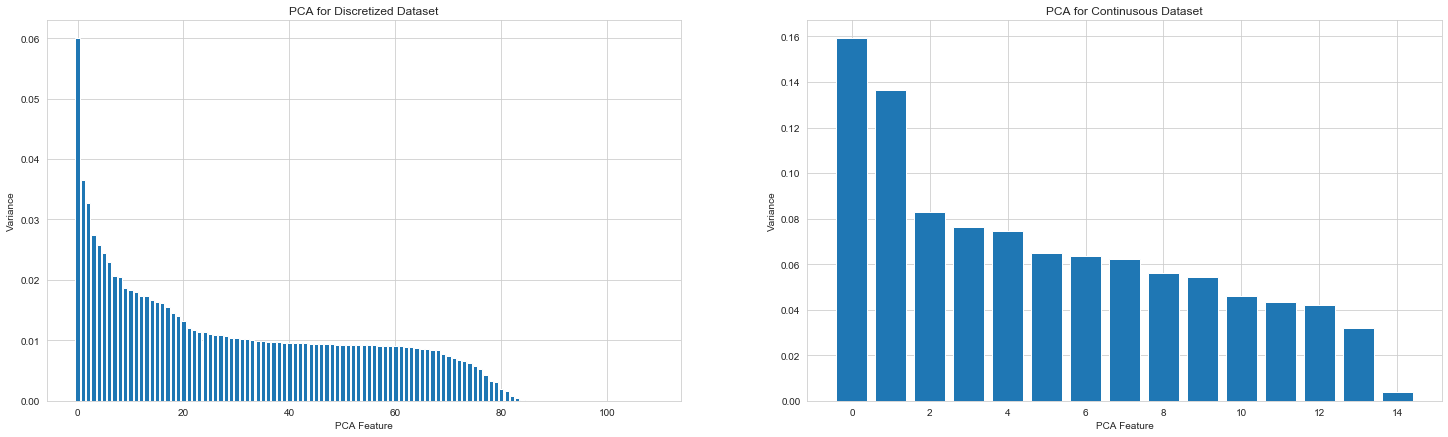

In [60]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

std_scale = StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca_1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit_1 = pca_1.fit(X)

std_scale = StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca_2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit_2 = pca_2.fit(X)

# Graphing the variance per feature
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretized Dataset')
plt.bar(range(0,fit_1.explained_variance_ratio_.size), fit_1.explained_variance_ratio_)

plt.subplot(1,2,2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continusous Dataset')
plt.bar(range(0,fit_2.explained_variance_ratio_.size), fit_2.explained_variance_ratio_)

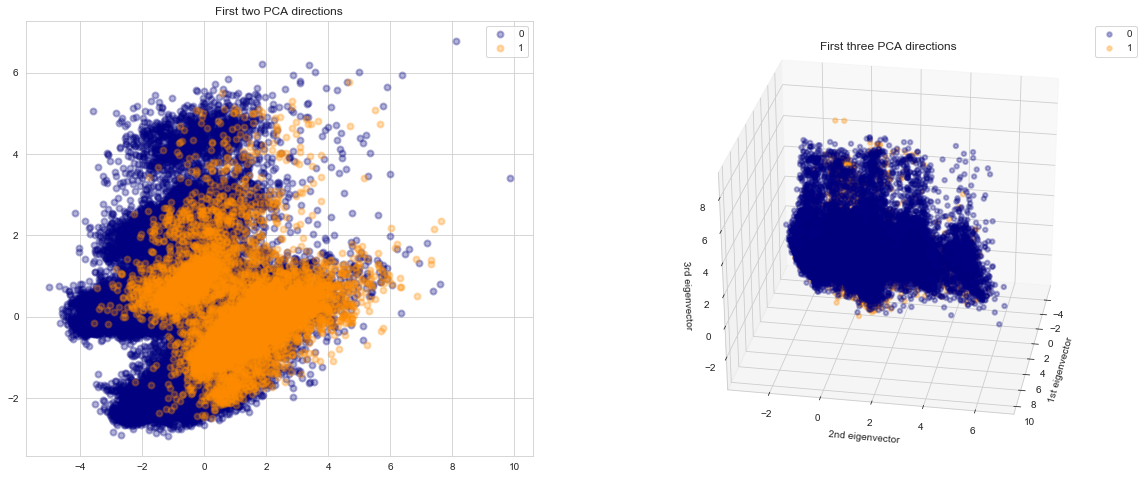

In [70]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = StandardScaler().fit_transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# Formatting
target_names = [0,1]
colors = ['navy', 'darkorange']
lw = 2
alpha = 0.3

# 2 Components PCA
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
pca_2d = PCA(n_components=2).fit_transform(std_scale)
for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(pca_2d[y==i,0], pca_2d[y==i,1],color=color,alpha=alpha,lw=lw,label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1) 
plt.title('First two PCA directions')

# 3 Components PCA
#from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(1,2,2, projection='3d')
pca_3d = PCA(n_components=3).fit_transform(std_scale)
for color, i, target_name in zip(colors, [0,1], target_names):
    ax.scatter(pca_3d[y==i,0], pca_3d[y==i,1], pca_3d[y==i,2],color=color,alpha=alpha,lw=lw,label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions") 
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30,10)

#### 遞歸特徵消除 RFECV: Recursive feature elimination with cross-validation

遞歸特徵消除的主要思想是反覆的構建模型(如SVM或者回歸模型)，然後選出最好(或者最差)的特稱(可以根據係數來選)，把選出來的特徵放到一邊，然後再剩餘的特徵上重複這個過程，直到所有特徵都遍歷了。這個過程中特徵被消除的次序就是特徵的排序，因此這是一種 '尋找最優特徵子集的貪心算法'

- step ： 整數時，每次去除的特徵個數，小於1時，每次去除權重最小的特徵
- scoring ：字符串類型，選擇sklearn中的scorer作為輸入對象
- cv ：默認為3折，整數為cv數
- object：用作交叉驗證生成器的對象
- n_jobs：Number of cores to run in parallel while fitting across folds (-1 means using all processors)

Feature Ranking For Non-Discretised: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 16


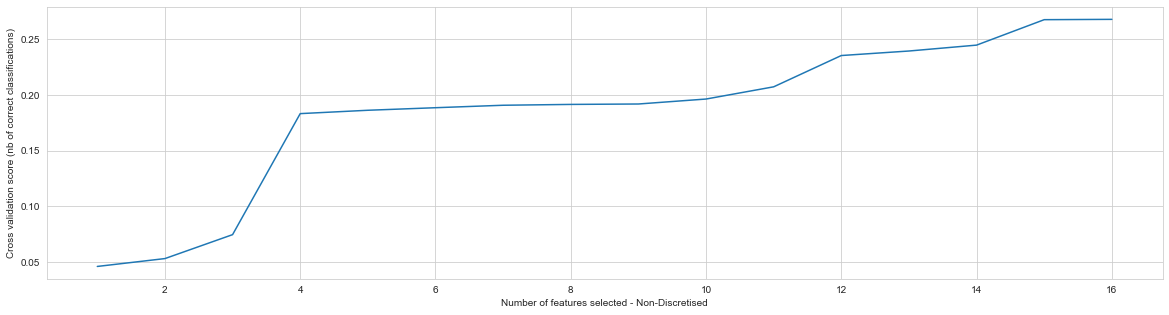

In [81]:
#from sklearn.feature_selection import RFECV
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector = RFECV(LinearRegression(),cv=5, n_jobs=-1).fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'].values)
print("Feature Ranking For Non-Discretised: %s" % selector.ranking_) 
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20,5))
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)

# Feature space could be subsetted like so:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector.support_, 0, True)]]

#### 選擇不同的編碼數據集

分別嘗試下不同機器學習算法的效果

In [83]:
# OPTIONS: 
# - dataset_bin_enc
# - dataset_con_enc
selected_dataset = dataset_con_enc

# Splitting the Training and Test data sets, and 去掉缺失值
train = selected_dataset.loc[0:32560,:].dropna(axis=0)
test = selected_dataset.loc[32560:,:].dropna(axis=0)

# rename
X_train_w_label = train
X_train = train.drop('predclass',axis=1)
y_train = train['predclass'].astype('int64')
X_test = test.drop('predclass',axis=1)
y_test = test['predclass'].astype('int64')

In [84]:
import random
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(1)

## 機器學習算法



- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

在sklearn中有很多通用函數，可以自定義一套方案

#### ROC 與 AUC

In [102]:
#from sklearn.metrics import roc_curve, auc
# 在不同阈值上計算fpr
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr)) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    
    plt.title('Receiver Operating Characteristic') 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [93]:
#from sklearn.model_selection import cross_val_predict
#from sklearn.metrics import accuracy_score

# 返回结果
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
       #isinstance() 函數來判斷一個對像是否是一個已知的class
    if (isinstance(algo, (LogisticRegression, KNeighborsClassifier, GaussianNB, DecisionTreeClassifier,
                          RandomForestClassifier,GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = 'Not Available'
    
    acc = round(model.score(X_test,y_test)*100, 2)    
    
    # CV: 對數據集進行指定次數的交叉驗證並為每次驗證效果評測
    train_pred = cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs=-1)
    acc_cv = round(accuracy_score(y_train,train_pred)*100, 2)
    
    return train_pred, test_pred, acc, acc_cv, probs

#### Logistic Regression - Random Search for Hyperparameters

In [90]:
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i) 
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate],results['std_test_score'][candidate])) 
            print("Parameters: {0}".format(results['params'][candidate])) 
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty':['l2', 'l1'], 'class_weight':[None, 'balanced'], 
              'C':np.logspace(-20, 20, 10000), 'intercept_scaling':np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, n_jobs=-1, param_distributions=param_dist, n_iter=n_iter_search)

import time
start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV took 22.66 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.805 (std: 0.004)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.4668299575403516e-19, 'class_weight': None, 'C': 245945615.02449164}

Model with rank: 2
Mean validation score: 0.801 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1254.0355001210544, 'class_weight': None, 'C': 298227.33989305136}

Model with rank: 3
Mean validation score: 0.783 (std: 0.001)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.754787056907328e-18, 'class_weight': 'balanced', 'C': 9.756609653272268e-08}

Model with rank: 4
Mean validation score: 0.775 (std: 0.005)
Parameters: {'penalty': 'l1', 'intercept_scaling': 0.0019486281535619017, 'class_weight': 'balanced', 'C': 677927292345.3245}

Model with rank: 5
Mean validation score: 0.767 (std: 0.006)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.2136917806911218e-19, 'class_weight': 'balanced', 'C': 15682653315

#### Logistic Regression

/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy: 80.12
Accuracy CV 10-Fold: 80.36
Running Time: 0:00:02.080255

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     24720
           1       0.72      0.31      0.43      7841

    accuracy                           0.80     32561
   macro avg       0.77      0.63      0.65     32561
weighted avg       0.79      0.80      0.77     32561

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     12435
           1       0.69      0.29      0.41      3847

    accuracy                           0.80     16282
   macro avg       0.75      0.62      0.64     16282
weighted avg       0.78      0.80      0.77     16282



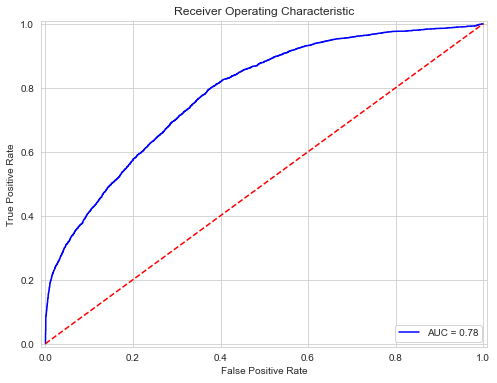

In [103]:
#from sklearn.metrics import classification_report
#import datetime
#import time

start_time = time.time()
log = LogisticRegression(n_jobs=-1)
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(log, X_train, y_train, X_test, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

print()
print(classification_report(y_train, train_pred_log))
print(classification_report(y_test, test_pred_log))
plot_roc_curve(y_test, probs_log)

#### k-Nearest Neighbors

Accuracy: 76.53
Accuracy CV 10-Fold: 76.21
Running Time: 0:00:05.496163

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     24720
           1       0.51      0.39      0.44      7841

    accuracy                           0.76     32561
   macro avg       0.66      0.64      0.65     32561
weighted avg       0.75      0.76      0.75     32561

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12435
           1       0.50      0.38      0.44      3847

    accuracy                           0.77     16282
   macro avg       0.66      0.63      0.64     16282
weighted avg       0.75      0.77      0.75     16282



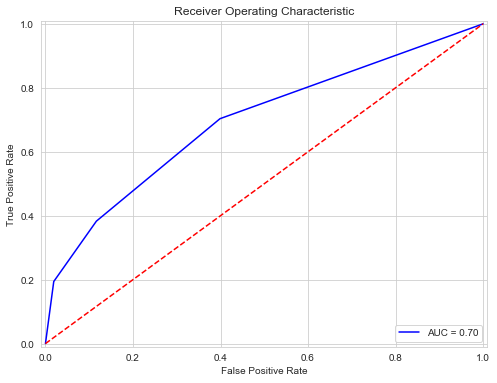

In [105]:
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors = 3,n_jobs = -1)
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(knn, X_train, y_train, X_test, 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

print()
print(classification_report(y_train, train_pred_knn))
print(classification_report(y_test, test_pred_knn))
plot_roc_curve(y_test, probs_knn)

#### Gaussian Naive Bayes

Accuracy: 79.55
Accuracy CV 10-Fold: 79.56
Running Time: 0:00:00.670294

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     24720
           1       0.66      0.31      0.42      7841

    accuracy                           0.80     32561
   macro avg       0.74      0.63      0.65     32561
weighted avg       0.78      0.80      0.77     32561

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     12435
           1       0.64      0.31      0.41      3847

    accuracy                           0.80     16282
   macro avg       0.73      0.63      0.64     16282
weighted avg       0.77      0.80      0.77     16282



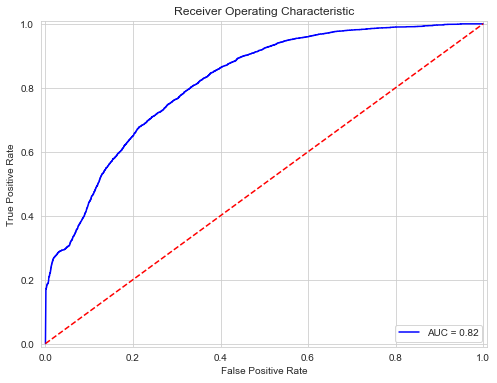

In [106]:
start_time = time.time()
gaussian = GaussianNB()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gaussian = fit_ml_algo(gaussian,X_train,y_train,X_test,10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

print()
print(classification_report(y_train, train_pred_gaussian))
print(classification_report(y_test, test_pred_gaussian))
plot_roc_curve(y_test, probs_gaussian)

#### Linear SVC

In [109]:
start_time = time.time()
svc = LinearSVC()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(svc,X_train,y_train,X_test,10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

print()
print(classification_report(y_train, train_pred_knn))
print(classification_report(y_test, test_pred_knn))

/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 77.03
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:39.898696

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     24720
           1       0.51      0.39      0.44      7841

    accuracy                           0.76     32561
   macro avg       0.66      0.64      0.65     32561
weighted avg       0.75      0.76      0.75     32561

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12435
           1       0.50      0.38      0.44      3847

    accuracy                           0.77     16282
   macro avg       0.66      0.63      0.64     16282
weighted avg       0.75      0.77      0.75     16282



#### Stochastic Gradient Descent

In [112]:
start_time = time.time()
sgd = SGDClassifier(n_jobs = -1)
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(sgd,X_train,y_train,X_test,10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

print()
print(classification_report(y_train, train_pred_sgd))
print(classification_report(y_test, test_pred_sgd))

Accuracy: 78.13
Accuracy CV 10-Fold: 61.87
Running Time: 0:00:07.890853

              precision    recall  f1-score   support

           0       0.79      0.68      0.73     24720
           1       0.30      0.43      0.35      7841

    accuracy                           0.62     32561
   macro avg       0.54      0.55      0.54     32561
weighted avg       0.67      0.62      0.64     32561

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     12435
           1       0.80      0.10      0.18      3847

    accuracy                           0.78     16282
   macro avg       0.79      0.55      0.53     16282
weighted avg       0.79      0.78      0.71     16282



#### Decision Tree Classifier

Accuracy: 81.13
Accuracy CV 10-Fold: 81.07
Running Time: 0:00:02.466845

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     24720
           1       0.60      0.62      0.61      7841

    accuracy                           0.81     32561
   macro avg       0.74      0.75      0.74     32561
weighted avg       0.81      0.81      0.81     32561

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12435
           1       0.60      0.60      0.60      3847

    accuracy                           0.81     16282
   macro avg       0.74      0.74      0.74     16282
weighted avg       0.81      0.81      0.81     16282



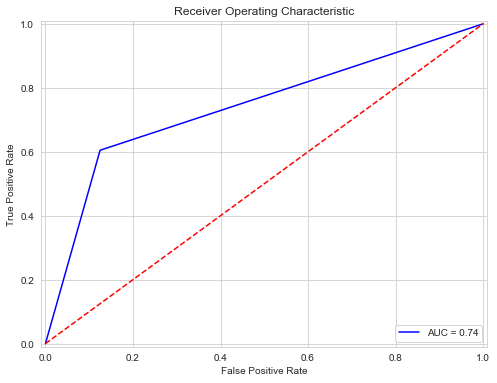

In [113]:
start_time = time.time()
dt = DecisionTreeClassifier()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(dt,X_train,y_train,X_test,10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

print()
print(classification_report(y_train, train_pred_dt))
print(classification_report(y_test, test_pred_dt))
plot_roc_curve(y_test, probs_dt)

#### Random Forest Classifier - Random Search for Hyperparameters

In [120]:
# Random Forest Classifier - Random Search for Hyperparameters
            
# Specify parameters and distributions to sample from
param_dist_rfc = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
                  "max_depth": [10, None], "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(2, 20), "min_samples_leaf": sp_randint(1, 11),
                  "bootstrap": [True, False], "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search_rfc = 10
rfc = RandomForestClassifier()
random_search_rfc = RandomizedSearchCV(rfc, n_jobs=-1, param_distributions=param_dist_rfc, n_iter=n_iter_search_rfc)

start = time.time()
random_search_rfc.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"" parameter settings." % ((time.time() - start), n_iter_search_rfc))
report(random_search_rfc.cv_results_)
print(random_search_rfc.best_estimator_)
print(random_search_rfc.best_score_)

/Users/dan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV took 861.37 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.861 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 2000}

Model with rank: 2
Mean validation score: 0.860 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 1200}

Model with rank: 3
Mean validation score: 0.859 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 1000}

Model with rank: 4
Mean validation score: 0.859 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 1200}

Model with rank: 5
Mean valida

#### Random Forest Classifier

Accuracy: 86.05
Accuracy CV 10-Fold: 86.05
Running Time: 0:09:56.565244

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24720
           1       0.78      0.59      0.67      7841

    accuracy                           0.86     32561
   macro avg       0.83      0.77      0.79     32561
weighted avg       0.85      0.86      0.85     32561

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.77      0.58      0.66      3847

    accuracy                           0.86     16282
   macro avg       0.83      0.76      0.79     16282
weighted avg       0.85      0.86      0.85     16282



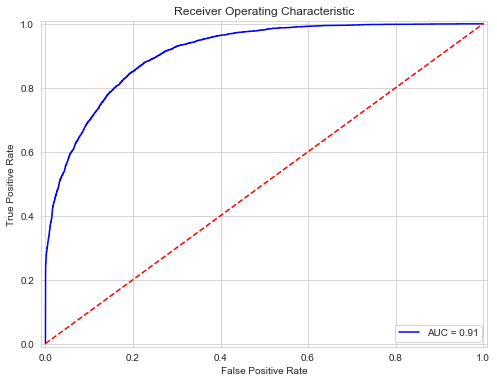

In [122]:
start_time = time.time()
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train_pred_rfc, test_pred_rfc, acc_rfc, acc_cv_rfc, probs_rfc = fit_ml_algo(rfc,X_train,y_train,X_test,10)
rfc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rfc)
print("Accuracy CV 10-Fold: %s" % acc_cv_rfc)
print("Running Time: %s" % datetime.timedelta(seconds=rfc_time))

print()
print(classification_report(y_train, train_pred_rfc))
print(classification_report(y_test, test_pred_rfc))
plot_roc_curve(y_test, probs_rfc)

#### Gradient Boosting Trees

Accuracy: 86.57
Accuracy CV 10-Fold: 86.38
Running Time: 0:00:24.758745

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24720
           1       0.79      0.59      0.68      7841

    accuracy                           0.86     32561
   macro avg       0.83      0.77      0.80     32561
weighted avg       0.86      0.86      0.86     32561

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     12435
           1       0.79      0.59      0.67      3847

    accuracy                           0.87     16282
   macro avg       0.84      0.77      0.79     16282
weighted avg       0.86      0.87      0.86     16282



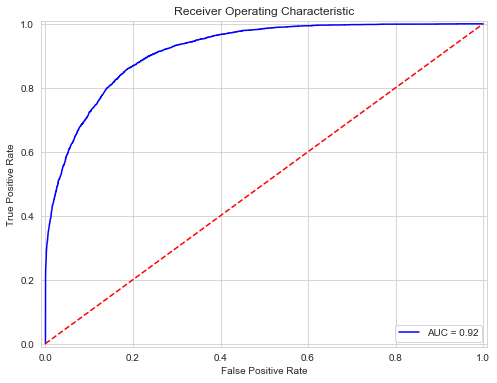

In [123]:
start_time = time.time()
gbt = GradientBoostingClassifier()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(gbt, X_train,y_train,X_test,10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

print()
print(classification_report(y_train, train_pred_gbt))
print(classification_report(y_test, test_pred_gbt))
plot_roc_curve(y_test, probs_gbt)

## Ranking Results

Let's rank the results for all the algorithms we have used

In [124]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [acc_knn, acc_log, acc_rfc, acc_gaussian, acc_sgd, acc_linear_svc, acc_dt, acc_gbt]
})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,86.57
2,Random Forest,86.05
6,Decision Tree,81.13
1,Logistic Regression,80.12
3,Naive Bayes,79.55
4,Stochastic Gradient Decent,78.13
5,Linear SVC,77.03
0,KNN,76.53


In [125]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [acc_cv_knn, acc_cv_log, acc_cv_rfc, acc_cv_gaussian, acc_cv_sgd, acc_cv_linear_svc, acc_cv_dt, acc_cv_gbt]
})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,86.38
2,Random Forest,86.05
6,Decision Tree,81.07
1,Logistic Regression,80.36
3,Naive Bayes,79.56
0,KNN,76.21
5,Linear SVC,73.68
4,Stochastic Gradient Decent,61.87
